# Classification d'images avec TensorFlow + Albumentations + TensorBoard + Matrice de confusion


## Imports nécessaires

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import albumentations as A
import numpy as np
import os
import glob
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import mlflow
import mlflow.tensorflow


## 2. Paramètres globaux

On fixe les hyperparamètres principaux comme la taille des images, le nombre de classes, la taille des lots (batch size) et le nombre d’époques (epochs) pour l’entraînement.

In [6]:
batch_size = 8                     # Nombre d’images traitées avant une mise à jour des poids (taille de lot).
img_height, img_width = 224,224   # Dimensions d'entrée des images (toutes les images seront redimensionnées à cette taille).
num_classes = 13                   # Nombre total de classes à prédire.
epochs = 100                       # Nombre de cycles d’entraînement complets (passe sur toutes les données).

## 3. Vérification du nombre d’images par classe

Le programme parcourt les sous-dossiers du dossier principal afin de compter et d’afficher le nombre d’images disponibles dans chaque classe. Cela permet de vérifier l’équilibre ou le déséquilibre du dataset.

In [7]:
data_dir = "C:/Users/Utilisateur/Documents/WorldAIprint/notebooks/images"  # Chemin vers le dossier principal contenant les classes.
for class_dir in os.listdir(data_dir):   # Boucle sur chaque sous-dossier (chaque classe).
    class_path = os.path.join(data_dir, class_dir)  # Construit le chemin absolu vers ce sous-dossier.
    if os.path.isdir(class_path):    # Vérifie que c’est bien un dossier (et pas un fichier).
        num_images = len(glob.glob(os.path.join(class_path, "*.*")))  # Compte toutes les images de ce dossier.
        print(f"Classe {class_dir}: {num_images} images")  # Affiche le nombre d’images trouvées pour cette classe.


Classe Castor: 17 images
Classe Chat: 19 images
Classe Chien: 24 images
Classe Coyote: 21 images
Classe Ecureuil: 19 images
Classe Lapin: 11 images
Classe Loup: 18 images
Classe Lynx: 24 images
Classe Ours: 22 images
Classe Puma: 22 images
Classe Rat: 10 images
Classe Raton laveur: 23 images
Classe Renard: 22 images


## 4. Transformation Albumentations (augmentation simple)

Un pipeline d’augmentations est défini avec Albumentations :retournements horizontaux, ajustements de luminosité/contraste. Ces transformations enrichissent artificiellement le dataset et améliorent la robustesse du modèle.

In [8]:
transform = A.Compose([                                      # On définit une composition de transformations (pipeline).
    A.HorizontalFlip(p=0.5),                                 # Flip horizontal avec 50% de chance.
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), # Variation aléatoire luminosité/contraste.
])

## 5. Fonction d’augmentation avec Albumentations

On définit une fonction qui applique ces augmentations aux images et normalise les valeurs de pixels entre 0 et 1. Les labels sont également ajustés pour être utilisables par le modèle (entier unique par classe).

In [9]:
def apply_albumentations(image, label):                            # Prend une image + son label en entrée.
    try:
        image = image.astype(np.uint8)   # Conversion en uint8 (format attendu par Albumentations).
        augmented = transform(image=image)  # Application des transformations définies plus haut.
        image_aug = augmented["image"]         # Récupère l’image transformée.
        image_aug = tf.convert_to_tensor(image_aug, dtype=tf.float32) / 255.0     # Conversion → tenseur + normalisation [0,1].
        return image_aug, label                # Retourne l’image augmentée et son label.
    except Exception as e:                     # En cas d’erreur...
        print(f"Erreur lors de l'augmentation: {e}")  
        image_aug = tf.cast(image, tf.float32) / 255.0  # On normalise l’image sans augmentation.
        return image_aug, label


## 6. Fonction de prétraitement (wrapper pour tf.data)

Avec la fonction process_data on prépare chaque paire (image, label) pour l’entraînement. Elle applique d’abord les augmentations définies dans apply_albumentations, puis gère le format des labels : si le label est encodé en one-hot, elle prend l’indice correspondant à la classe. Ensuite, elle reshape le label en scalaire et fixe explicitement la forme de l’image pour TensorFlow. En sortie, on obtient une image normalisée et augmentée prête à être utilisée par le modèle, avec son label correctement formaté.

In [10]:
def process_data(image, label):                          # Fonction appliquée à chaque (image, label).
    image, label = tf.numpy_function(                    # Permet d’appliquer une fonction numpy dans un pipeline TF.
        func=apply_albumentations,                       # On utilise notre fonction d’augmentation.
        inp=[image, label],                              # Entrées.
        Tout=[tf.float32, tf.int32]                      # Types de sortie (image: float32, label: int32).
    )
    image.set_shape((img_height, img_width, 3))          # On fixe la shape de l’image (important pour TF).
    label = tf.reshape(label, ())                        # Force le label à être scalaire.
    return image, label                                  # Retourne l’image prête + son label.


## 7. Chargement des datasets

Les images sont chargées directement depuis les dossiers grâce à image_dataset_from_directory. Le dataset est automatiquement séparé en un ensemble d’entraînement (80%) et de validation (20%).

In [11]:
# Charger le dataset complet
full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,                   # Chemin vers le dossier contenant toutes les images classées par sous-dossier
    seed=42,                     # Pour assurer la reproductibilité du shuffle
    image_size=(img_height, img_width),  # Redimensionner toutes les images à la taille souhaitée
    batch_size=None,             # On ne fait pas encore de batch, on veut diviser les images individuellement
    color_mode="rgb",            # Charger les images en 3 canaux (R,G,B)
    shuffle=True                 # Mélanger les images avant la division
)


Found 252 files belonging to 13 classes.


In [12]:
# Calculer la taille de chaque split
dataset_size = sum(1 for _ in full_ds)       # Nombre total d'images dans le dataset
train_size = int(0.7 * dataset_size)         # 70% des images pour l'entraînement
val_size = int(0.15 * dataset_size)          # 15% des images pour la validation
test_size = dataset_size - train_size - val_size  # Le reste pour le test (15%)


In [13]:
# Diviser le dataset en train / val / test
train_ds = full_ds.take(train_size)                  # Prend les premiers train_size exemples
val_ds = full_ds.skip(train_size).take(val_size)    # Saute les train_size premières images, prend val_size suivantes
test_ds = full_ds.skip(train_size + val_size)       # Saute train+val images, prend le reste pour test


## 8. Calcul des poids de classes (pour gérer déséquilibre)

On calcule des poids de classes en fonction de la fréquence des labels. Ces poids permettront au modèle de ne pas être biaisé par les classes majoritaires.

In [14]:
train_labels = []                           # Liste vide pour stocker les labels.
for _, labels in train_ds:                  # Boucle sur le dataset (x,y).
    train_labels.append(labels.numpy())     # Récupère les labels et stocke en numpy.

train_labels = np.array(train_labels)       # Conversion en numpy array.
class_weights = compute_class_weight(       # Calcule les poids par classe (équilibrage).
    'balanced', 
    classes=np.unique(train_labels),        # Liste des classes uniques.
    y=train_labels                          # Labels observés.
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}  # Convertit en dictionnaire.
print("Poids de classe :", class_weights)   # Affiche les poids obtenus.

Poids de classe : {0: np.float64(1.353846153846154), 1: np.float64(1.1282051282051282), 2: np.float64(0.967032967032967), 3: np.float64(0.8461538461538461), 4: np.float64(0.8461538461538461), 5: np.float64(1.934065934065934), 6: np.float64(1.0414201183431953), 7: np.float64(0.7521367521367521), 8: np.float64(0.9025641025641026), 9: np.float64(0.967032967032967), 10: np.float64(1.6923076923076923), 11: np.float64(0.967032967032967), 12: np.float64(0.7125506072874493)}


## 9. Application du prétraitement + batching

Les datasets sont transformés pour appliquer le prétraitement, regroupés en lots (batchs), et optimisés avec prefetch pour accélérer l’entraînement.

In [15]:
# Appliquer le prétraitement et batching pour l'entraînement
train_ds = train_ds.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)  # Appliquer les augmentations et prétraitement
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)            # Créer les batches et précharger pour accélérer

# Prétraitement pour validation
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y),         # Normalise les images val [0,1].
                    num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Prétraitement pour test
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y), 
                      num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


## 10. Définition du modèle CNN from scratch

Le modèle est un CNN (réseau de neurones convolutionnel) séquentiel :
- Plusieurs couches convolutionnelles avec normalisation et dropout pour éviter le surapprentissage.
- Une couche de global average pooling pour réduire les dimensions
- Une couche dense finale avec une activation softmax pour classifier les 13 classes.

In [16]:
def build_model():
    model = models.Sequential([                       # On utilise un modèle séquentiel (couches empilées les unes après les autres).
        layers.InputLayer(input_shape=(img_height, img_width, 3)),   # Couche d'entrée, chaque image est de taille 128x128 avec 3 canaux (RGB).

        layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)), # Convolution avec 32 filtres, taille 3x3. "relu" pour non-linéarité. Régularisation L2 pour éviter le surapprentissage.
        layers.BatchNormalization(),                  # Normalisation pour stabiliser l'apprentissage.
        layers.MaxPooling2D(),                        # Réduction de dimension par sous-échantillonnage.
        layers.Dropout(0.3),                          # Dropout : désactive 30% des neurones pour limiter le surapprentissage.

        layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)), # Deuxième bloc convolutionnel, plus de filtres (64).
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)), # Troisième bloc convolutionnel.
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)), # Quatrième bloc convolutionnel.
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),              # Remplace les couches denses intermédiaires par une moyenne globale → réduit le nombre de paramètres.
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # Couche dense classique avec 256 neurones.
        layers.Dropout(0.5),                          # Dropout plus élevé pour éviter le surapprentissage.
        layers.Dense(num_classes, activation='softmax')  # Couche de sortie : une probabilité pour chaque classe (13 au total).
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Optimiseur Adam avec un taux d'apprentissage de 0.001.
        loss='sparse_categorical_crossentropy',                  # Fonction de perte adaptée à des labels  one-hot encodés.
        metrics=['accuracy']                                     # On suit la précision comme métrique principale.
    )
    return model


In [17]:
model = build_model()   # Construction du modèle.
model.summary()         # Affiche le résumé du modèle : couches, paramètres, tailles de sortie.

C:\Users\Utilisateur\anaconda3\envs\nom_environnement\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 13)                  │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 459,469 (1.75 MB)

 Trainable params: 458,509 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

## 11. Entraînement avec callbacks (incluant TensorBoard)

Le modèle est entraîné sur les données d’entraînement et validé sur un ensemble de test. Les callbacks améliorent l’efficacité :
- EarlyStopping arrête l’entraînement si le modèle ne progresse plus,
- ReduceLROnPlateau ajuste automatiquement le taux d’apprentissage,
- ModelCheckpoint sauvegarde le meilleur modèle,
- TensorBoard permet de suivre les performances en temps réel.

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')   # Active TensorBoard pour visualiser l'entraînement dans un tableau de bord.

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),   # Arrête l'entraînement si la validation n'évolue plus pendant 10 epochs, et restaure les meilleurs poids.
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5),               # Si la validation stagne 5 epochs, réduit le learning rate par 10.
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True), # Sauvegarde automatiquement le meilleur modèle pendant l'entraînement.
    tensorboard_callback  # Ajout de TensorBoard dans les callbacks.
]

history = model.fit(
    train_ds,                            # Dataset d'entraînement.
    validation_data=val_ds,              # Dataset de validation.
    epochs=epochs,                       # Nombre maximum d'epochs (100).
    callbacks=callbacks,                 # Les callbacks définis ci-dessus.
    class_weight=class_weights           # Poids de classes pour équilibrer les classes minoritaires.
)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.0564 - loss: 8.3481

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.0909 - loss: 8.2782 - val_accuracy: 0.0811 - val_loss: 7.7417 - learning_rate: 0.0010
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.1015 - loss: 8.0624

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step - accuracy: 0.0852 - loss: 8.1106 - val_accuracy: 0.0541 - val_loss: 7.4708 - learning_rate: 0.0010
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.1063 - loss: 7.7091

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/step - accuracy: 0.0909 - loss: 7.6457 - val_accuracy: 0.1081 - val_loss: 7.1468 - learning_rate: 0.0010
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.1824 - loss: 7.1258

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.1364 - loss: 7.1953 - val_accuracy: 0.0811 - val_loss: 6.9358 - learning_rate: 0.0010
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.0782 - loss: 6.9820

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.1080 - loss: 6.8784 - val_accuracy: 0.1622 - val_loss: 6.7263 - learning_rate: 0.0010
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 326ms/step - accuracy: 0.1193 - loss: 6.5434 - val_accuracy: 0.0000e+00 - val_loss: 7.0407 - learning_rate: 0.0010
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.1136 - loss: 6.1642 - val_accuracy: 0.0270 - val_loss: 6.8057 - learning_rate: 0.0010
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.0786 - loss: 5.9943

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step - accuracy: 0.0852 - loss: 5.9844 - val_accuracy: 0.0541 - val_loss: 6.4829 - learning_rate: 0.0010
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.1636 - loss: 5.6885

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.1364 - loss: 5.6599 - val_accuracy: 0.0541 - val_loss: 6.2199 - learning_rate: 0.0010
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.0955 - loss: 5.5406

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.0795 - loss: 5.4657 - val_accuracy: 0.0541 - val_loss: 6.1061 - learning_rate: 0.0010
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.1655 - loss: 5.0975

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.1705 - loss: 5.2255 - val_accuracy: 0.1081 - val_loss: 5.9290 - learning_rate: 0.0010
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.0845 - loss: 5.2740

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 382ms/step - accuracy: 0.1080 - loss: 5.1812 - val_accuracy: 0.1622 - val_loss: 5.3794 - learning_rate: 0.0010
Epoch 13/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.1532 - loss: 5.0011

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.1307 - loss: 5.0284 - val_accuracy: 0.0811 - val_loss: 5.2240 - learning_rate: 0.0010
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.1354 - loss: 4.9043

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.1136 - loss: 4.7780 - val_accuracy: 0.0541 - val_loss: 5.0379 - learning_rate: 0.0010
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.1080 - loss: 4.7443 - val_accuracy: 0.0541 - val_loss: 5.3840 - learning_rate: 0.0010
Epoch 16/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.1023 - loss: 4.5478 - val_accuracy: 0.1892 - val_loss: 5.0529 - learning_rate: 0.0010
Epoch 17/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.1366 - loss: 4.3044

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.1193 - loss: 4.3688 - val_accuracy: 0.0811 - val_loss: 4.5184 - learning_rate: 0.0010
Epoch 18/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.1591 - loss: 4.1892 - val_accuracy: 0.0541 - val_loss: 4.8061 - learning_rate: 0.0010
Epoch 19/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.1343 - loss: 4.0726

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.1136 - loss: 4.0921 - val_accuracy: 0.1622 - val_loss: 4.3918 - learning_rate: 0.0010
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.1307 - loss: 4.0620 - val_accuracy: 0.1622 - val_loss: 4.5040 - learning_rate: 0.0010
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.1260 - loss: 4.1464

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - accuracy: 0.1250 - loss: 4.0457 - val_accuracy: 0.0270 - val_loss: 4.3477 - learning_rate: 0.0010
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.1364 - loss: 3.9764 - val_accuracy: 0.0541 - val_loss: 10.2035 - learning_rate: 0.0010
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.1460 - loss: 3.7658

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.1591 - loss: 3.8003 - val_accuracy: 0.0270 - val_loss: 4.0394 - learning_rate: 0.0010
Epoch 24/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.1618 - loss: 3.6796

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.1534 - loss: 3.6882 - val_accuracy: 0.0270 - val_loss: 3.9318 - learning_rate: 0.0010
Epoch 25/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.2281 - loss: 3.5094

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.2159 - loss: 3.5828 - val_accuracy: 0.1622 - val_loss: 3.7343 - learning_rate: 0.0010
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.1591 - loss: 3.5975 - val_accuracy: 0.1351 - val_loss: 4.5667 - learning_rate: 0.0010
Epoch 27/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 326ms/step - accuracy: 0.1534 - loss: 3.6100 - val_accuracy: 0.1081 - val_loss: 4.7078 - learning_rate: 0.0010
Epoch 28/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.1743 - loss: 3.4252

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.1534 - loss: 3.4630 - val_accuracy: 0.1351 - val_loss: 3.3490 - learning_rate: 0.0010
Epoch 29/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.1875 - loss: 3.3238 - val_accuracy: 0.1081 - val_loss: 3.9452 - learning_rate: 0.0010
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.1875 - loss: 3.4896 - val_accuracy: 0.0270 - val_loss: 4.7269 - learning_rate: 0.0010
Epoch 31/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.1636 - loss: 3.3552

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.1761 - loss: 3.2962 - val_accuracy: 0.2162 - val_loss: 3.2543 - learning_rate: 0.0010
Epoch 32/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.2102 - loss: 3.1763 - val_accuracy: 0.1081 - val_loss: 5.0849 - learning_rate: 0.0010
Epoch 33/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.1120 - loss: 3.3037

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.1080 - loss: 3.2749 - val_accuracy: 0.2432 - val_loss: 3.0252 - learning_rate: 0.0010
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.1697 - loss: 3.1732

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.1648 - loss: 3.2369 - val_accuracy: 0.2703 - val_loss: 2.9905 - learning_rate: 0.0010
Epoch 35/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.2045 - loss: 3.1397 - val_accuracy: 0.1351 - val_loss: 3.1960 - learning_rate: 0.0010
Epoch 36/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.2590 - loss: 3.0024

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.1818 - loss: 3.0395 - val_accuracy: 0.1892 - val_loss: 2.9810 - learning_rate: 0.0010
Epoch 37/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - accuracy: 0.2102 - loss: 3.0962 - val_accuracy: 0.2162 - val_loss: 3.0307 - learning_rate: 0.0010
Epoch 38/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.2229 - loss: 2.9795

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.2159 - loss: 3.0853 - val_accuracy: 0.2703 - val_loss: 2.8450 - learning_rate: 0.0010
Epoch 39/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.1534 - loss: 3.1265 - val_accuracy: 0.0811 - val_loss: 3.2161 - learning_rate: 0.0010
Epoch 40/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.1307 - loss: 3.0816 - val_accuracy: 0.0541 - val_loss: 7.1049 - learning_rate: 0.0010
Epoch 41/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.1420 - loss: 3.1515 - val_accuracy: 0.0270 - val_loss: 3.3740 - learning_rate: 0.0010
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.1193 - loss: 3.0328 - val_accuracy: 0.0000e+00 - val_loss: 4.0303 - learning_rate: 0.0010
Epoch 43/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.1812 - loss: 3.0262

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.2045 - loss: 3.0386 - val_accuracy: 0.1892 - val_loss: 2.7165 - learning_rate: 0.0010
Epoch 44/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 348ms/step - accuracy: 0.1818 - loss: 2.8936 - val_accuracy: 0.0000e+00 - val_loss: 4.5670 - learning_rate: 0.0010
Epoch 45/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.1591 - loss: 2.9728 - val_accuracy: 0.1081 - val_loss: 3.3464 - learning_rate: 0.0010
Epoch 46/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.1875 - loss: 2.9538 - val_accuracy: 0.2432 - val_loss: 3.0208 - learning_rate: 0.0010
Epoch 47/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.1705 - loss: 2.9203 - val_accuracy: 0.1351 - val_loss: 2.9352 - learning_rate: 0.0010
Epoch 48/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.2045 - loss: 2.8722 - val_accuracy: 0.1622 - val_loss: 2.8226 - learning_rate: 0.0010
Epoch 49/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.1875 - loss: 2.77

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step - accuracy: 0.2330 - loss: 2.7877 - val_accuracy: 0.2703 - val_loss: 2.6125 - learning_rate: 1.0000e-04
Epoch 51/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.1774 - loss: 2.7437

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.1761 - loss: 2.7888 - val_accuracy: 0.3243 - val_loss: 2.5295 - learning_rate: 1.0000e-04
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.2216 - loss: 2.7141 - val_accuracy: 0.2703 - val_loss: 2.5664 - learning_rate: 1.0000e-04
Epoch 53/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.1648 - loss: 2.8343 - val_accuracy: 0.3514 - val_loss: 2.5308 - learning_rate: 1.0000e-04
Epoch 54/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.2587 - loss: 2.5742

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step - accuracy: 0.2216 - loss: 2.6577 - val_accuracy: 0.2162 - val_loss: 2.4517 - learning_rate: 1.0000e-04
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.2159 - loss: 2.6919 - val_accuracy: 0.2162 - val_loss: 2.7497 - learning_rate: 1.0000e-04
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 345ms/step - accuracy: 0.2102 - loss: 2.7179 - val_accuracy: 0.2162 - val_loss: 2.5990 - learning_rate: 1.0000e-04
Epoch 57/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - accuracy: 0.2330 - loss: 2.6585 - val_accuracy: 0.3243 - val_loss: 2.5092 - learning_rate: 1.0000e-04
Epoch 58/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.2784 - loss: 2.5321 - val_accuracy: 0.3514 - val_loss: 2.5188 - learning_rate: 1.0000e-04
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.2372 - loss: 2.6438

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/step - accuracy: 0.2330 - loss: 2.6825 - val_accuracy: 0.3514 - val_loss: 2.3264 - learning_rate: 1.0000e-04
Epoch 60/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 344ms/step - accuracy: 0.2386 - loss: 2.6995 - val_accuracy: 0.3514 - val_loss: 2.4783 - learning_rate: 1.0000e-04
Epoch 61/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.2557 - loss: 2.6385 - val_accuracy: 0.2973 - val_loss: 2.5225 - learning_rate: 1.0000e-04
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.2784 - loss: 2.5584 - val_accuracy: 0.2432 - val_loss: 2.4769 - learning_rate: 1.0000e-04
Epoch 63/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.2386 - loss: 2.5653 - val_accuracy: 0.3514 - val_loss: 2.3591 - learning_rate: 1.0000e-04
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step - accuracy: 0.2386 - loss: 2.5641 - val_accuracy: 0.2162 - val_loss: 2.5284 - learning_rate: 1.0000e-04
Epoch 65/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 341ms/step - accuracy:

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step - accuracy: 0.2670 - loss: 2.5754 - val_accuracy: 0.2973 - val_loss: 2.2837 - learning_rate: 1.0000e-05
Epoch 69/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.3011 - loss: 2.5114 - val_accuracy: 0.2432 - val_loss: 2.4189 - learning_rate: 1.0000e-05
Epoch 70/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 346ms/step - accuracy: 0.2784 - loss: 2.5556 - val_accuracy: 0.2703 - val_loss: 2.4783 - learning_rate: 1.0000e-05
Epoch 71/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.2727 - loss: 2.6213 - val_accuracy: 0.2973 - val_loss: 2.4344 - learning_rate: 1.0000e-05
Epoch 72/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.2011 - loss: 2.6161

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step - accuracy: 0.2216 - loss: 2.6381 - val_accuracy: 0.5405 - val_loss: 2.1490 - learning_rate: 1.0000e-05
Epoch 73/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.2670 - loss: 2.5549 - val_accuracy: 0.1892 - val_loss: 2.5062 - learning_rate: 1.0000e-05
Epoch 74/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 338ms/step - accuracy: 0.2500 - loss: 2.6074 - val_accuracy: 0.3784 - val_loss: 2.3670 - learning_rate: 1.0000e-05
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step - accuracy: 0.3125 - loss: 2.5096 - val_accuracy: 0.4054 - val_loss: 2.3402 - learning_rate: 1.0000e-05
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.2216 - loss: 2.6594 - val_accuracy: 0.3784 - val_loss: 2.3572 - learning_rate: 1.0000e-05
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step - accuracy: 0.2841 - loss: 2.6291 - val_accuracy: 0.1892 - val_loss: 2.6457 - learning_rate: 1.0000e-05
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step - accuracy:

## 12. Visualisation des prédictions sur un batch

Après l’entraînement, on affiche un petit lot d’images de validation avec leurs classes réelles et celles prédites par le modèle. Cela donne une première idée qualitative des performances.

In [19]:
images, labels = next(iter(val_ds))      # Récupère un batch d'images et de labels depuis le dataset de validation.
predictions = model.predict(images)      # Prédit les probabilités de classes pour ces images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


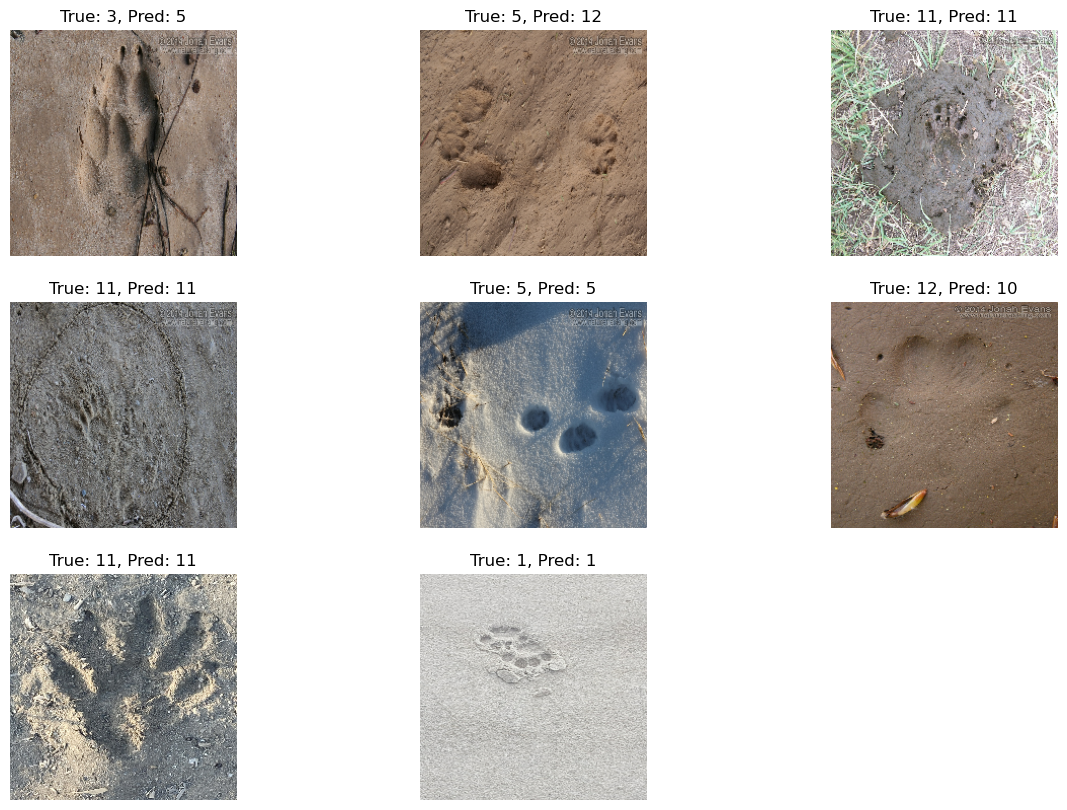

In [20]:
num_images = min(9, len(images))         # On choisit d’afficher au maximum 9 images.
plt.figure(figsize=(15, 10))             # Prépare une figure matplotlib.
for i in range(num_images):              # Boucle sur les images sélectionnées.
    plt.subplot(3, 3, i+1)               # Crée une grille 3x3 pour afficher jusqu'à 9 images.
    plt.imshow(images[i])                # Affiche l’image.
    plt.title(f"True: {labels[i].numpy()}, Pred: {np.argmax(predictions[i])}") # Titre avec label réel et prédiction.
    plt.axis('off')                      # Supprime les axes pour un affichage plus clair.
plt.show()                               # Affiche le tout.


## 13. Visualisation des courbes d’entraînement

Enfin, on trace les courbes de précision (accuracy) et de perte (loss) pour comparer l’évolution entre entraînement et validation. Ces graphiques permettent de détecter un éventuel surapprentissage ou sous-apprentissage.

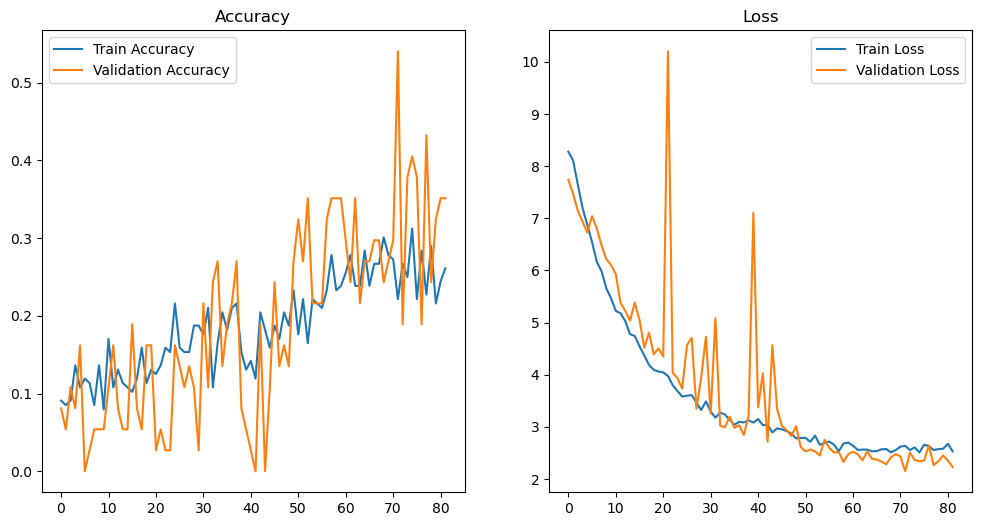

In [21]:
plt.figure(figsize=(12, 6))             # Crée une figure avec deux sous-graphes côte à côte.

plt.subplot(1, 2, 1)                    # Premier graphique (accuracy).
plt.plot(history.history['accuracy'], label='Train Accuracy')         # Précision sur l’entraînement.
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Précision sur la validation.
plt.title('Accuracy')                   # Titre du graphique.
plt.legend()                            # Ajoute la légende.

plt.subplot(1, 2, 2)                    # Deuxième graphique (loss).
plt.plot(history.history['loss'], label='Train Loss')                 # Perte sur l’entraînement.
plt.plot(history.history['val_loss'], label='Validation Loss')        # Perte sur la validation.
plt.title('Loss')                       # Titre du graphique.
plt.legend()                            # Ajoute la légende.

plt.show()                              # Affiche les deux graphiques.


Les courbes montrent une instabilité marquée dans l'apprentissage :
- Train Accuracy et Validation Accuracy sont très fluctuantes, avec une tendance à la hausse, mais sans stabilisation claire.
- Train Loss et Validation Loss diminuent globalement, mais avec des pics fréquents, ce qui suggère un apprentissage irrégulier et un risque de surapprentissage (overfitting). Le modèle peine à généraliser correctement sur les données de validation.

## 14. Matrice de confusion

La matrice de confusion est un tableau qui compare, pour chaque classe, le nombre d’images bien classées (diagonale) et mal classées (hors diagonale).
Elle permet de voir où le modèle se trompe le plus souvent et d’identifier les classes difficiles à distinguer. C’est un outil plus fin que la simple précision globale.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


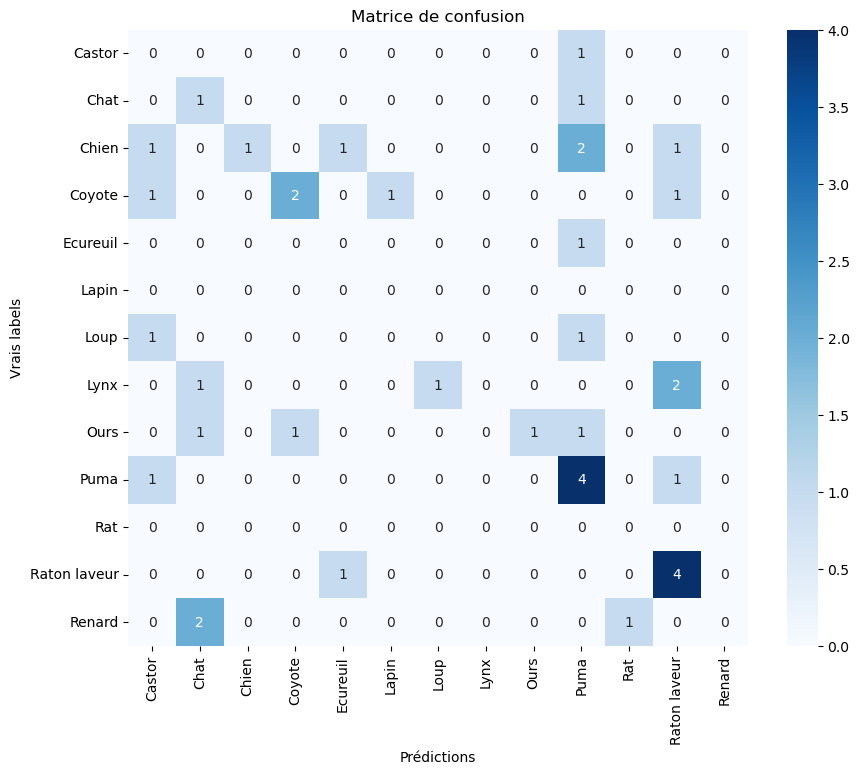

In [22]:
# Liste des classes
class_names = ['Castor', 'Chat', 'Chien', 'Coyote', 'Ecureuil', 'Lapin', 'Loup', 
               'Lynx', 'Ours', 'Puma', 'Rat', 'Raton laveur', 'Renard']


#Récupère toutes les prédictions sur la validation
all_labels = []   # Liste pour stocker les vrais labels
all_preds = []    # Liste pour stocker les prédictions

# Parcourt le dataset de validation batch par batch
for batch_images, batch_labels in test_ds:
    batch_preds = model.predict(batch_images)               # Calcule les probabilités pour chaque image du batch
    all_preds.extend(np.argmax(batch_preds, axis=1))        # Stocke la classe prédite (indice du max)
    all_labels.extend(batch_labels.numpy())                 # Stocke les vrais labels

# Calcule la matrice de confusion
cm = confusion_matrix(all_labels, all_preds)

# Affiche la matrice sous forme de carte de chaleur
plt.figure(figsize=(10, 8))                                 # Définit la taille de la figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)          # Affiche la matrice avec le snom de classes et un dégradé bleu
plt.title("Matrice de confusion")                           # Ajoute un titre
plt.xlabel("Prédictions")                                   # Nom de l’axe X
plt.ylabel("Vrais labels")                                  # Nom de l’axe Y
plt.show()                                                  # Affiche le graphique


La matrice de confusion révèle :
- Peu de prédictions correctes (valeurs sur la diagonale), sauf pour la classe Puma (4 bonnes prédictions).
- Beaucoup de confusions entre classes (ex. : classe castor prédite comme classe Puma, classe Ranard prédite comme classe rat).
- Certaines classes (ex. : loup, lynx, ours) ne sont presque jamais prédites correctement, ce qui peut indiquer un déséquilibre des données ou une mauvaise séparation des caractéristiques entre ces classes.

Le modèle a du mal à apprendre de manière stable et à généraliser, avec des performances inégales selon les classes. Il est clai rqu el emodele n' apas assez de données mais surtout qu'elles ne sont pas de quantité uniforme sur toutes les lcasses. C'est pourquoi nous allons essayer un modèle pré entrainer afin d'améliorer les performances.

In [23]:
from sklearn.metrics import classification_report

# Générer et afficher le rapport de classification
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Rapport de classification :\n")
print(report)

Rapport de classification :

              precision    recall  f1-score   support

      Castor       0.00      0.00      0.00         1
        Chat       0.20      0.50      0.29         2
       Chien       1.00      0.17      0.29         6
      Coyote       0.67      0.40      0.50         5
    Ecureuil       0.00      0.00      0.00         1
       Lapin       0.00      0.00      0.00         0
        Loup       0.00      0.00      0.00         2
        Lynx       0.00      0.00      0.00         4
        Ours       1.00      0.25      0.40         4
        Puma       0.36      0.67      0.47         6
         Rat       0.00      0.00      0.00         0
Raton laveur       0.44      0.80      0.57         5
      Renard       0.00      0.00      0.00         3

    accuracy                           0.33        39
   macro avg       0.28      0.21      0.19        39
weighted avg       0.47      0.33      0.31        39



C:\Users\Utilisateur\anaconda3\envs\nom_environnement\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Utilisateur\anaconda3\envs\nom_environnement\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Utilisateur\anaconda3\envs\nom_environnement\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## 14. modèle pré-entraîné (EfficientNet)

On utilise EfficientNetB0 comme extracteur de caractéristiques (entraîné sur ImageNet).
- On gèle ses poids pour d’abord entraîner uniquement la tête de classification.
- On ajoute une couche GlobalAveragePooling2D + Dropout + Dense softmax adaptée à 13 classes.
Cela permet d’entraîner beaucoup plus vite, avec de meilleures performances sur peu de données.

In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model
import tensorflow as tf

def build_pretrained_model_resnet():
    """
    Construit un modèle basé sur ResNet50 pré-entraîné sur ImageNet,
    adapté à 13 classes et compatible avec des images RGB.
    """
    # Charger ResNet50 sans la tête finale, avec poids ImageNet
    base_model = ResNet50(
        weights="imagenet",        # Poids pré-entraînés
        include_top=False,         # On enlève la dernière couche de classification
        input_shape=(img_height, img_width, 3)  # 3 canaux RGB
    )

    base_model.trainable = True # Décongeler seulement les dernières couches si le dataset est petit
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Ajouter une "tête" personnalisée pour notre problème
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)   # Réduit les dimensions en un vecteur
    x = layers.Dropout(0.5)(x)               # Régularisation
    output = layers.Dense(num_classes, activation="softmax")(x)  # Sortie pour 13 classes

    # Créer le modèle final
    model = Model(inputs=base_model.input, outputs=output)

    # Compiler le modèle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Construction du modèle
model = build_pretrained_model_resnet()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,614,349 (90.08 MB)

 Trainable params: 8,957,965 (34.17 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [25]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 516ms/step - accuracy: 0.0511 - loss: 3.0778 - val_accuracy: 0.1351 - val_loss: 12.0338 - learning_rate: 0.0010
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 434ms/step - accuracy: 0.0795 - loss: 2.7995 - val_accuracy: 0.0541 - val_loss: 12.6437 - learning_rate: 0.0010
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - accuracy: 0.0795 - loss: 2.8896 - val_accuracy: 0.0541 - val_loss: 7.0472 - learning_rate: 0.0010
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.0625 - loss: 2.8183 - val_accuracy: 0.0811 - val_loss: 4.6765 - learning_rate: 0.0010
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 448ms/step - accuracy: 0.0568 - loss: 2.8350 - val_accuracy: 0.1622 - val_loss: 3.2984 - learning_rate: 0.0010
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 462ms/step - accuracy: 0.1193 - loss: 2.6883 - val_accuracy: 0.1622 - val_loss: 2.6839 - learning_rate: 1.0000e-04
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.07

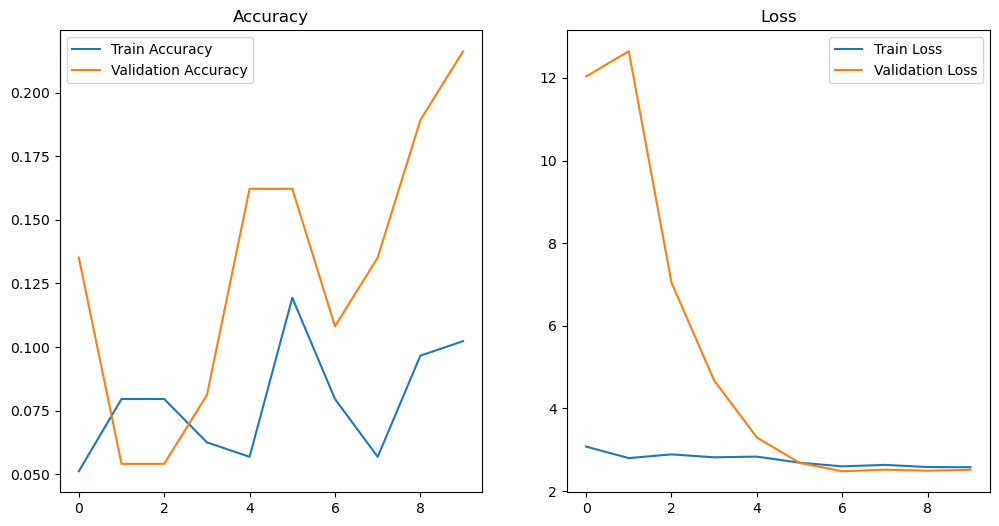

In [26]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


Les courbes de Train Accuracy et Validation Accuracy sont très instables, avec des fluctuations importantes.
La Validation Accuracy dépasse parfois la Train Accuracy, ce qui est inhabituel et peut indiquer un problème dans la séparation des données ou un apprentissage très irrégulier.
Les valeurs d'accuracy restent faibles (autour de 0.16 maximum), ce qui suggère que le modèle a du mal à apprendre correctement.

La Train Loss diminue progressivement, mais la Validation Loss présente un pic extrême au début, suivi d'une baisse rapide.
Après quelques époques, les deux courbes de perte se stabilisent à un niveau bas, mais cela ne se traduit pas par une amélioration significative de l'accuracy.

Le modèle semble peu performant et instable. Les fluctuations importantes et la faible accuracy indiquent un problème d'apprentissage, potentiellement lié à un mauvais choix d'hyperparamètres, un déséquilibre des données, ou une architecture inadaptée.


Peu de prédictions correctes (valeurs sur la diagonale), sauf pour certaines classes comme la classe 5 (3 bonnes prédictions) et la classe 7 (3 bonnes prédictions).
Beaucoup de confusions entre classes, notamment entre les classes 0 et 1, 6 et 5, et 12 et 9.
Certaines classes (ex. : 0, 1, 4, 8, 10) ne sont presque jamais prédites correctement.

Interprétation :
Le modèle a du mal à distinguer les classes, ce qui peut être dû à un manque de données, un déséquilibre de classes, ou des caractéristiques peu discriminantes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


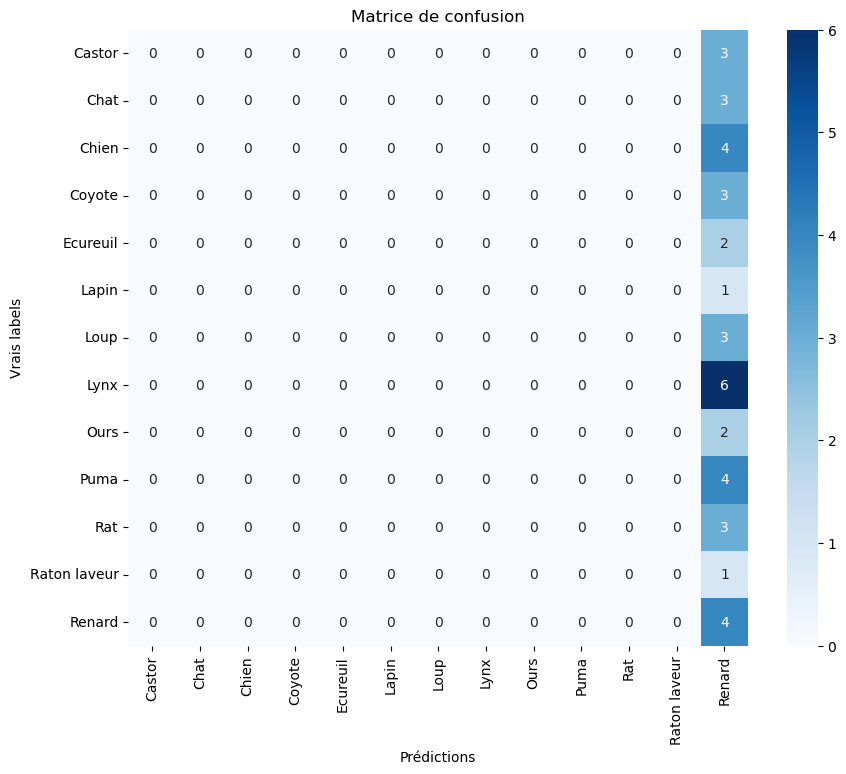

In [27]:
# Liste des classes
class_names = ['Castor', 'Chat', 'Chien', 'Coyote', 'Ecureuil', 'Lapin', 'Loup', 
               'Lynx', 'Ours', 'Puma', 'Rat', 'Raton laveur', 'Renard']


#Récupère toutes les prédictions sur la validation
all_labels = []   # Liste pour stocker les vrais labels
all_preds = []    # Liste pour stocker les prédictions

# Parcourt le dataset de validation batch par batch
for batch_images, batch_labels in test_ds:
    batch_preds = model.predict(batch_images)               # Calcule les probabilités pour chaque image du batch
    all_preds.extend(np.argmax(batch_preds, axis=1))        # Stocke la classe prédite (indice du max)
    all_labels.extend(batch_labels.numpy())                 # Stocke les vrais labels

# Calcule la matrice de confusion
cm = confusion_matrix(all_labels, all_preds)

# Affiche la matrice sous forme de carte de chaleur
plt.figure(figsize=(10, 8))                                 # Définit la taille de la figure
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)          # Affiche la matrice avec le snom de classes et un dégradé bleu
plt.title("Matrice de confusion")                           # Ajoute un titre
plt.xlabel("Prédictions")                                   # Nom de l’axe X
plt.ylabel("Vrais labels")                                  # Nom de l’axe Y
plt.show()                                                  # Affiche le graphique


Il semblerait que le modèle ne prédisse que les renard pour tous les animaux, il y a clairement un gors problème d'enttrainement.

Interprétation :
Le modèle a une très faible capacité de généralisation et ne parvient pas à distinguer correctement les classes. Cela peut être dû à :
- Un déséquilibre des données (certaines classes sous-représentées).
- Des caractéristiques peu discriminantes entre les classes.
- Un manque de données d'entraînement ou une mauvaise qualité des données.